<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-final/blob/main/simulate_BallAndStick_soma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll first install neuron as usual.

In [ ]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Run the code block below to mount the google drive folder with the rest of the model files. Save your files in a folder in your main google drive folder and set `drive_folder_name` equal to it as a string. It also compiles the mod files in the `mechanisms` folder

In [1]:
repo_name = 'CompModNervSys-final'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/lw-miles24/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

/content/CompModNervSys-final
Mod files: "mechanisms/mechanisms/kv.mod" "mechanisms/mechanisms/na.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Now we can import the packages we'll be using

In [2]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
import plotly
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()


Create the Ball and Stick neuron model

In [74]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.06 # 0 to 1, if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
cell = BallAndStick(0,ais_mode,ais_loc)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 1 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
       `--------------------|       BallAndStick[0].ais_prox(0-1)
                             `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                   `------------------------|       BallAndStick[0].axon(0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)
|-----|       BallAndStick[0].soma(0-1)
       `-----------------------------------------------------------------------------------------------------------------------------------------------------

Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma. (see Exercise 9 for detail instructions on how to make synapses)

In [75]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
exc_syn = h.Exp2Syn(cell.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential
# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

In [76]:
# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance

Define helper function to convert between `x` values (normalized distance along a cable) and the segment index (a number between `0` and `nseg-1`) within the dendrite.

In [77]:
def xind(vec,val):
    # finds closest value to x in x_vals vector, outputs index
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

dend0_x_vals = np.array([seg.x for seg in cell.dend[0]])
dend1_x_vals = np.array([seg.x for seg in cell.dend[1]])

def didfire(v_vec,threshold=20):
    # returns 1 if Vm gets over threshold mV
    for val in v_vec:
        if val > threshold:
            return 1
    return 0

In [78]:
exc_range = np.linspace(0,0.12,13)
inh_range = np.linspace(0,0.08,9)
iclamp.amp=0

fire_matrix = np.zeros((len(exc_range),len(inh_range)))

for e in np.arange(0,len(exc_range)):
    for i in np.arange(0,len(inh_range)):
        nc_estim.weight[0] = exc_range[e]
        nc_istim.weight[0] = inh_range[i]
        h.run()
        fire_matrix[e,i] = didfire(cell.ais_v,20)

In [79]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=fire_matrix,x=inh_range*1e3,y=exc_range*1e3))
fig.update_xaxes(title_text="Inhibitory weight (nS)")
fig.update_yaxes(title_text="Excitatory weight (nS)")
fig.show()

In [48]:
exc_range = np.linspace(0,0.12,13)
inh_range = np.linspace(0,0.08,9)
fire_matrix = np.zeros((len(inh_range),len(exc_range)))
i = 0
e = 0
fire_matrix[i,e]

0.0

Set amplitude of current pulse, excitatory synapse, and/or inhibitory synapse, run, and plot

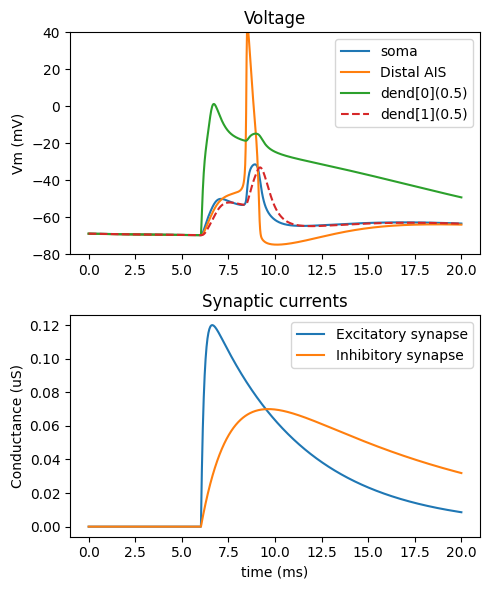

In [19]:
nc_estim.weight[0] = 0.120
# 0.009 seems to be threshold for AP initiation
nc_istim.weight[0] = 0.07
iclamp.amp=0
h.run()

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(211) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
# Uncomment to plot other voltages
ax0.plot(t_vec,cell.ais_v,label='Distal AIS')
ax0.plot(t_vec,cell.dend0_vs[xind(dend0_x_vals,0.5)],label='dend[0](0.5)')
ax0.plot(t_vec,cell.dend1_vs[xind(dend1_x_vals,0.5)],label='dend[1](0.5)',ls='--')
# ax0.legend()
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax0.legend()
# ax1 = fig.add_subplot(312) # injected current
# ax1.plot(t_vec,iclamp_i)
# ax1.set_ylabel('Current (nA)')
# ax1.set_title('Somatic current injection')
ax2 = fig.add_subplot(212)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()